Import librairies

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

Import fichier

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

Nombre de classifications

In [5]:
NUM_CLASSES = 8

Split data

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [9]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Train

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/31 [..............................] - ETA: 26s - loss: 2.0020 - accuracy: 0.2188
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 1s 12ms/step - loss: 1.9649 - accuracy: 0.2539 - val_loss: 1.8299 - val_accuracy: 0.3280
Epoch 2/1000
 1/31 [..............................] - ETA: 0s - loss: 1.9145 - accuracy: 0.2656
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 0s 3ms/step - loss: 1.7717 - accuracy: 0.3369 - val_loss: 1.6280 - val_accuracy: 0.5042
Epoch 3/1000
 1/31 [..............................] - ETA: 0s - loss: 1.6556 - accuracy: 0.3750
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 0s 3ms/step - loss: 1.6329 - accuracy: 0.3886 - val_loss: 1.4746 - val_accuracy: 0.5608
Epoch 4/1000
 1/31 [..............................] - ETA: 0s - loss: 1.5507 - accuracy: 0.4062

In [12]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.9539


In [13]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 104ms/step
[9.81621683e-01 1.77322645e-02 5.67466486e-07 5.22351067e-04
 7.45270299e-08 1.99553863e-11 1.20497425e-04 2.52457448e-06]
0


Melanger les données

42/42 [==============================] - 0s 783us/step


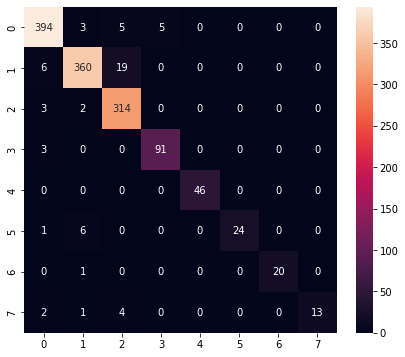

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       407
           1       0.97      0.94      0.95       385
           2       0.92      0.98      0.95       319
           3       0.95      0.97      0.96        94
           4       1.00      1.00      1.00        46
           5       1.00      0.77      0.87        31
           6       1.00      0.95      0.98        21
           7       1.00      0.65      0.79        20

    accuracy                           0.95      1323
   macro avg       0.97      0.90      0.93      1323
weighted avg       0.96      0.95      0.95      1323



In [14]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

Tensorflow Model

In [15]:
model.save(model_save_path, include_optimizer=False)

In [16]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\guill\AppData\Local\Temp\tmpi9rq04_b\assets


INFO:tensorflow:Assets written to: C:\Users\guill\AppData\Local\Temp\tmpi9rq04_b\assets


6720

In [17]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [18]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [20]:
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8162156e-01 1.7732278e-02 5.6746637e-07 5.2235142e-04 7.4527165e-08
 1.9955421e-11 1.2049752e-04 2.5245768e-06]
0
